# How_SHAP_Explains_ML_Model

This notebook intends to provide an overview of SHAP, a framework to improve model explainability, by focusing on the following four topics:

- What SHAP is?
- How SHAP works?
- What SHAP can do?
- How to use SHAP?

### What SHAP is?
Many frameworks have been proposed to help with improving the explainability and transparence of machine learning models. SHAP (SHapley Additive exPlanations) is one of the most popular frameworks that aims at providing explainability of machine learning algorithms.  SHAP takes a game-theory-inspired approach to explain the prediction of a machine learning model. The SHAP framework is now available in the open-source python library, SHAP, for everyone wants to understand how their models make prediction (“uncovering the blackbox”). 

### How SHAP works?
SHAP explains the output of a machine learning model by using Shapley values, a method from cooperative game theory. Shapley values is a solution to fairly distributing payoff to participating players based on the contributions by each player as they work in cooperation with each other to obtain the grand payoff.

The main idea behind SHAP framework is to explain Machine Learning models by measuring how much each feature contributes to the model prediction using Shapley values. The SHAP framework considers making a prediction for an instance in the dataset as a game, the gain (can be positive of negative) from playing the game is the difference between the actual prediction on this particular instance and the average prediction for all instances (base value). SHAP treats each feature value of the instance as a "player", who works with each other feature value to receive the gain (= the difference between predicted value and the base value). As different player (feature value) contributes to the game differently, Shapley values is the average marginal contribution by each player (feature value) across all possible coalitions. In short, Shapley values is calculated at instance level, and with the current set of feature values for a given instance, the marginal contribution of a feature value to the difference between the actual prediction on this particular instance and the base value is the estimated Shapley value for that feature value.

For detailed explanation of how SHAP values are calculated:
https://vknight.org/Year_3_game_theory_course/Content/Chapter_16_Cooperative_games/
https://christophm.github.io/interpretable-ml-book/shapley.html#general-idea

   
### What SHAP can do?
SHAP explains the output of machine learning models of all kinds.

•	Computes SHAP Values for model features at instance level
•	Computes SHAP Interaction Values including the interaction terms of features (only support SHAP TreeExplainer for now)
•	Visualize feature importance through plotting SHAP values:
    o	shap.summary_plot
    o	shap.dependence_plot
    o	shap.force_plot
    o	shap.decision_plot
    o	shap.waterfall_plot
    o	shap.image_plot

Note:
The Shap values computed by SHAP library is in the same unit of the model output, which means it varies by model. It could be “raw”, “probability”, “log-odds” or etc. You have the option to specify it when initiating a SHAP Explainer by setting parameter model_output.

### How to use SHAP?
1.	Initialize a SHAP Explainer that is compatible with the model to be explained
2.	Use the SHAP Explainer to compute Shap values for a set of X matrix (the explaining set)
3.	Create SHAP plots with SHAP values computed, the explaining set, and/or explainer.expcected_values


### Example SHAP Plots
To create example SHAP plots (see belows), I am using the [California Housing Prices](https://www.kaggle.com/camnugent/california-housing-prices) dataset from Kaggle and built a binary classification model(GradientBoostingClassifier from scikit-learn). The original target variable median_house_price (continuous) is converted to a categorical variable price_high_low (label 0 or 1), indicating the median_house_price is above 50 percentile or below 50 percentiles. The model is trained to classifier whether a house is at the higher price range or lower price range.


### SHAP library
https://github.com/slundberg/shap

In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
import random
from itertools import combinations

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from pandas.plotting import scatter_matrix
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn import utils

import os
import tarfile
import urllib

# libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sn
import matplotlib.colors as mcolors
from matplotlib import rcParams

# import 
import random
from itertools import combinations

import shap
shap.initjs()

import warnings
warnings.filterwarnings('ignore')

### Import Data

In [2]:
# Load data
# Data source: https://www.kaggle.com/camnugent/california-housing-prices

csv_path= "/Users/yuanhongzhang/Folders/xpresso/xgb_component/datasets/housing/housing.csv"

housing = pd.read_csv(csv_path)


Create two new variables:
* price_high_low (binary, 1 for median house value above 50th percentile, 0 for median house value below 50th percentile)
* price_high_low_m (multiclass, 4 classes to label median house value at first 25th, 50th, 75th and 100th percentile)

In [3]:
# Create a new target variable price_high_low (binary, 1 for median house value above 50 percentile)
housing["price_high_low"]= pd.qcut(housing.median_house_value, q=[0,0.5, 1])
housing["price_high_low"]= housing["price_high_low"].astype('category').cat.codes


In [4]:
housing["price_high_low_m"]= pd.qcut(housing.median_house_value, q=[0,0.25, 0.5, 0.75, 1])
housing["price_high_low_m"]= housing["price_high_low_m"].astype('category').cat.codes

### Prepare Data - Train Test Split

In [5]:
y = housing.loc[:,["median_house_value", "price_high_low", "price_high_low_m"]].copy()


In [6]:
X= housing.drop(labels=["median_house_value", "price_high_low","price_high_low_m"] , axis= 1)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
                                                   

### Feature Engineering

In [8]:
#identify and separate numerical and categorical columns
num_attribs = X_train.select_dtypes(include=[np.number]).columns
cat_attribs = [col for col in X_train.columns if col not in num_attribs]


In [9]:
# onehotencoder for categorical variables
enc = OneHotEncoder()
cat_transformed = enc.fit_transform(X_train[cat_attribs]).toarray()
cat_attribs_enc = [str(col) for col in enc.categories_[0]]

In [10]:
# create a pipeline for feature transformation
imputer = SimpleImputer(strategy="median")

#feature engineering pipeline for numerical features
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])


#build full pipelines for both numerical and categorical features
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

In [11]:
# transform training set
train_x_trans = full_pipeline.fit_transform(X_train)

In [12]:
# transform test set
test_x_trans = full_pipeline.transform(X_test)

In [13]:
# get the list of new column names
new_col_list = num_attribs.values.tolist() +  cat_attribs_enc

In [14]:
# adding column names back to train x
train_x_trans_df = pd.DataFrame(train_x_trans, columns =new_col_list )

# adding column names back to test x
test_x_trans_df = pd.DataFrame(test_x_trans, columns =new_col_list )

In [15]:
train_x_trans_df.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0   0.650904 -0.783153           -0.758685    -0.812571       -0.539528   
1  -1.319117  0.847598            0.352399    -0.002103       -0.181057   
2   0.660879 -0.872188            1.066667    -0.684094       -0.655853   
3   0.162139  0.102513           -0.361869    -0.487003       -0.356731   
4  -1.184457  0.885086           -1.155500     1.132092        1.582811   

   population  households  median_income  <1H OCEAN  INLAND  ISLAND  NEAR BAY  \
0   -0.614962   -0.585664      -1.521700        1.0     0.0     0.0       0.0   
1   -0.362823   -0.194657       0.182054        0.0     0.0     0.0       0.0   
2   -0.337522   -0.679505      -0.172328        1.0     0.0     0.0       0.0   
3    0.222592   -0.338026      -1.171732        0.0     1.0     0.0       0.0   
4    1.140412    1.580512       0.059986        1.0     0.0     0.0       0.0   

   NEAR OCEAN  
0         0.0  
1         1.0  
2         0.0  
3         0.0  
4         0.0

In [16]:
# columns available
new_col_list

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 '<1H OCEAN',
 'INLAND',
 'ISLAND',
 'NEAR BAY',
 'NEAR OCEAN']

### SHAP Values for SKLearn

####  Train gradient boosting model 
Train a gradient boosting model to classify whether the house value is high or low

In [17]:
from sklearn.ensemble import GradientBoostingClassifier
gb_clf = GradientBoostingClassifier(random_state=0).fit(train_x_trans,
                                                     y_train["price_high_low"])

#### Initiate SHAP explainer and compute SHAP Values

In [18]:
# select number of data samples to be explained
select = range(len(test_x_trans))
# create background data
background_data = shap.sample(test_x_trans, nsamples=100)
# create SHAP KernelExplainer
explainer = shap.TreeExplainer(gb_clf, background_data)
# Get SHAP values for the samples to be explain
shap_values = explainer.shap_values(test_x_trans[select])

In [19]:
# Expected value
expected_value = explainer.expected_value
print(f"Explainer expected value: {expected_value}")

Explainer expected value: -0.15840121745603938


In [20]:
# SHAP value
shap_values.shape

(6812, 13)

#### Compute SHAP Interaction Values

In [33]:
# select number of data samples to be explained
select = range(len(test_x_trans))
# You can provide a background dataset to the Explainer
#background_data = shap.sample(test_x_trans, nsamples=100)
# create SHAP KernelExplainer
explainer = shap.TreeExplainer(gb_clf)
# Get SHAP values for the samples to be explain
shap_values = explainer.shap_values(test_x_trans[select])
# Get SHAP Interaction values 
shap_interaction_values = explainer.shap_interaction_values(test_x_trans[select])

### shap.summary_plot

#### 1)	shap.summary_plot - dot type

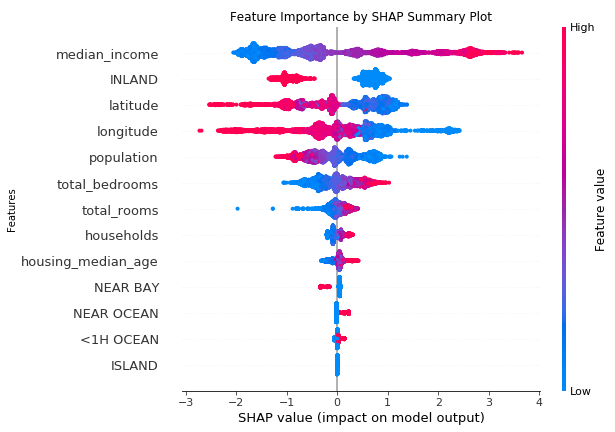

In [21]:
# The first argument is the matrix of SHAP values (it is the same shape as the data matrix)
# The second argument is the data matrix to explain (a pandas dataframe or numpy array)
# The third argument is provide feature names (optional)
# The forth argument is to deferred the showing function if you want to customize the plot

shap.summary_plot(shap_values, test_x_trans[select], feature_names= new_col_list,
                 show=False)
plt.title("Feature Importance by SHAP Summary Plot")
plt.ylabel("Features")
plt.savefig("shap_values_summary_plot.png") 
plt.show()

The summary plot (dot type) displays the SHAP values for model features at the individual samples/instances level.

- Every instance has one dot on each row
- The x-axis is SHAP value, the impact of a feature value on the model’s prediction/output. SHAP value (also, x-axis) is in the same unit as the output value (log-odds, output by GradientBoosting model in this example)
- The y-axis lists the model's features
- By default, the features are ranked by mean magnitude of SHAP values in descending order, and number of top features to include in the plot is 20. This plot shows that top 5 features affecting house price are
    * median income
    * INLAND(dummy variable from categorical variable Near Ocean)
    * latitude
    * longitude 
    * population (of the neighborhood) 
- The color of the dot represents the value of that feature for the instance, red indicates high value while blue indicates low value
    * median income : the higher median income (of the neighborhood), the more likely the house price is high
    * If the house is located INLAND (dots in red), the lower the house value
    * For houses with smaller latitude (dots in blue), the higher the house value(make senses as South California are more expensive than North California)



#### 2)shap.summary_plot - bar type

The summary plot (bar type) displays the SHAP values for model features at aggregate feature level (by averaging).

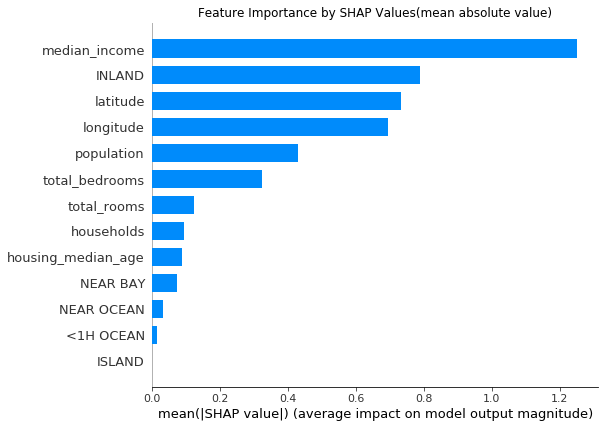

In [22]:
# Plot SHAP summary plot with bar type
shap.summary_plot(shap_values, test_x_trans[select], feature_names= new_col_list,
                  plot_type="bar", show= False )
plt.title("Feature Importance by SHAP Values(mean absolute value)")
plt.show()

- The y-axis lists the model's features
- The x-axis represents the mean absolute SHAP value for each feature, the impact of features on the model’s prediction/output. The x-axis is in the same unit as the model output (log-odds in this example)
- By default, the features are ranked by mean magnitude(absolute value) of SHAP values in descending order, and number of top features to include in the plot is 20. Similar to the dot-type summary plot, the bar plot shows that top 5 features affecting house price are also:
    * median income
    * INLAND(dummy variable from categorical variable Near Ocean)
    * latitude
    * longitude 
    * population (of the neighborhood) 


#### 3)shap.summary_plot – with SHAP Interaction Values
SHAP offers the option to take into account the effect of interaction terms on model prediction. The interpretation of this plot is the same as the regular summary plot above, with the additional interaction terms.


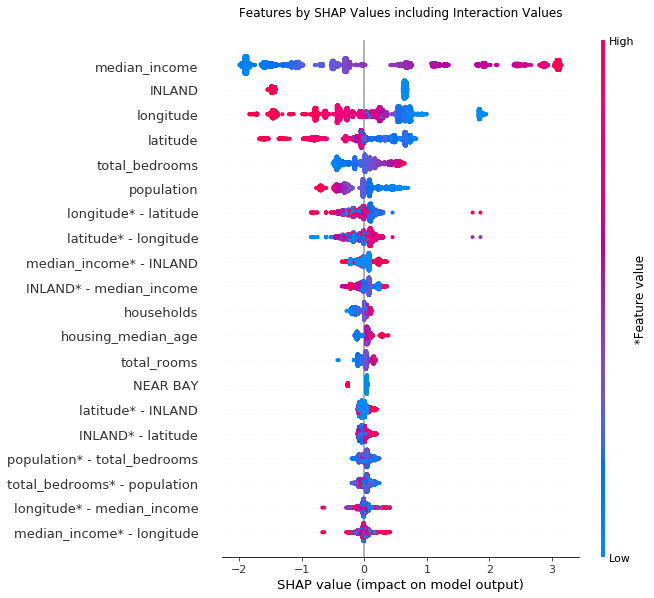

In [34]:
shap.summary_plot(shap_interaction_values, test_x_trans[select], 
                  plot_type="compact_dot",
                 feature_names= new_col_list, show =False)
plt.title("Features by SHAP Values including Interaction Values")
plt.show()
                  

### Rank Features by SHAP Values

Here I am going to rank features based on SHAP Values, the mean absolute value of shap values.

In [23]:
# Rank features based on SHAP Values (mean of the absolute value of shap values)
shap_values_abs = (np.abs(shap_values)).mean(axis = 0)
sorted_features = [f for _,f in sorted(zip(shap_values_abs, new_col_list), reverse=True)]
sorted_shap_values = [round(v,4) for v,_ in sorted(zip(shap_values_abs, new_col_list), 
                                                   reverse=True)]

#present features with their SHAP values in a sorted dataframe
pd.DataFrame({"features":sorted_features,
             "SHAP_values" : sorted_shap_values})

features  SHAP_values
0        median_income       1.2517
1               INLAND       0.7888
2             latitude       0.7338
3            longitude       0.6947
4           population       0.4304
5       total_bedrooms       0.3229
6          total_rooms       0.1233
7           households       0.0956
8   housing_median_age       0.0895
9             NEAR BAY       0.0751
10          NEAR OCEAN       0.0313
11           <1H OCEAN       0.0155
12              ISLAND       0.0000

### The Dependency Plot

A dependence plot is a scatter plot that shows the effect a single feature on the model prediction.
Here are some great examples from [SHAP github pages]( https://slundberg.github.io/shap/notebooks/plots/dependence_plot.html)

#### Plot dependece plot the top 3 most important features

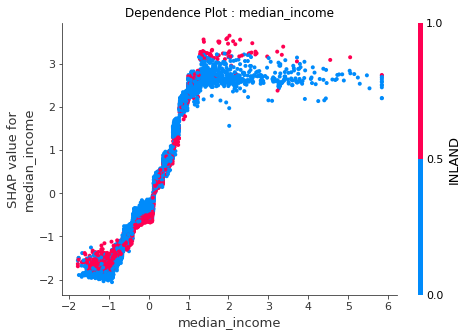

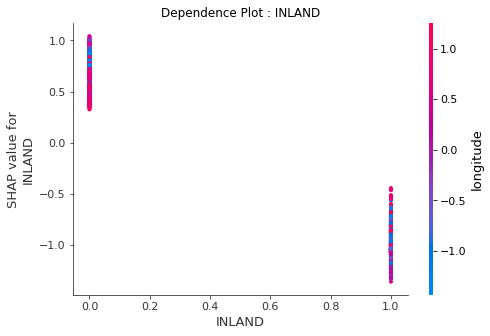

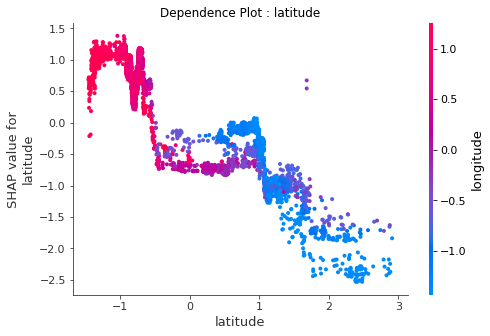

In [24]:
# The first argument is the feature name or index of the feature we want to plot
# The second argument is the matrix of SHAP values (it is the same shape as the data matrix)
# The third argument is the data matrix (a pandas dataframe or numpy array)

for i in range(3):
    shap.dependence_plot(sorted_features[i], shap_values, test_x_trans[select],
                        feature_names= new_col_list,
                        show=False)
    plt.title(f"Dependence Plot : {sorted_features[i]}")
    plt.show()


#### How to interprect Dependence plot?

For the first dependence plot - median_income:
- Each dot represents a single instance
- The x-axis is the value of median_income (the feature has been standard-scaled)
- The y-axis is the SHAP value for feature median_income (in the unit of log-odds in this example)
- The color of dots corresponds to a second feature, INLAND (in this example), that may have an interaction effect with the first feature, median_income, we are plotting (by default the second feature is chosen automatically)
- We can interpret the plot in 2 sections:
    * When median_income ranging from -2 to 1, there is a positive linear relationship between median_income and their corresponding SHAP values, which means that the higher values of median_income, the more contribution to the final prediction by feature median_income
    * When median_income is larger than 1, the relationship between median_income and their corresponding SHAP values is closer to a horizontal line, indicating that the contribution by feature median_income to the model prediction is the same once the value of median_income is greater than certain level


### Force plot

#### 1)shap.force_plot – individual instance

In [26]:
# random sample 1 observations
ob = random.sample(range(len(test_x_trans[select])), 1)

#plot the SHAP values for the random sampled observations
print(f"Force Plot of observation {ob}")
p = shap.force_plot(np.around(expected_value, decimals=4), 
                   np.around(shap_values[ob],decimals=4), 
                   test_x_trans[ob], 
                   feature_names= new_col_list)

p   

Force Plot of observation [4928]


SHAP Force Plot shows how each feature contributes to the model prediction for a particular instance
- Each feature is shown with its feature name along with its feature value in the data matrix (such as INLAND = 0, feature name = feature value)
- The x-axis presents the scale of model output values (log-odds in this example)
- The base value, -0.1584, is the average of all predictions by the model (same value as returned by explainer.expected_value)
- The model output value, 1.68, is the actual prediction made by the model on the current instance
- The features in red are the features dragging the model outputs to be higher than the model base value, while the features in blue are those features causing the model prediction to be lower than the base value. The combined positive and negative effects led to the final prediction value as 1.68.
- The size of the red and blue arrows indicating the magnitude of SHAP values for each feature, that is the contribution by each feature
- For this instance, Inland, total_bedrooms, median_income are top 3 features that have positive effect on the model output, while population and longitude are top 2 features that have negative effect on model output


#### 2)	shap.force_plot – single instance (predicted probability)

The force plot offers an option to plot the predicted probability instead of the raw prediction by setting parameter link=”logit”. The axis shows the predicted probability (range between 0 and 1) 

In [27]:
#plot the SHAP values for the random sampled observations with predicted probability
print(f"Force Plot of observation {ob}")
p = shap.force_plot(np.around(expected_value, decimals=4), 
                   np.around(shap_values[ob],decimals=4), 
                   test_x_trans[ob], 
                   feature_names= new_col_list,
                   link="logit")

p   

Force Plot of observation [4928]


#### 3)shap.force_plot – the collective plot

In [25]:
# The collective force plot
p=shap.force_plot(expected_value, shap_values, test_x_trans[select],
                        feature_names= new_col_list)
# save to html file
shap.save_html('SHAP_force_plot(collective).html', p)
p

The SHAP Force Plot is able to show how each feature contributes to the model prediction on a collection of instances (examples in the explaining set)
- The x-axis presents the index of instances/samples in the explain set
- The y-axis presents the model outputs (log-odds in this example)
- When hover over the plot, the instance at the location where the mouse stops is shown with top features by SHAP values. Each feature is shown with its feature name along with its feature value. The features in red have positive effect (increases) on the model output while features in blue have negative effect on (decrease) the model output 
- One vertical line represents one instance, with the length of the line representing the magnitude of SHAP values and the color of the line indicating whether positive-effect(in red) or negative-effect (in blue)by those features
- Currently the plot is showing instance #2721 and the model output is 5.277. For this instance, median_income, Inland, longitude, total_rooms are top 3 features that have positive effect on the model output, while population is top 1 feature that have negative effect on model output.



#### Force Plot converted to matplotlib image

Force Plot of observation 3377


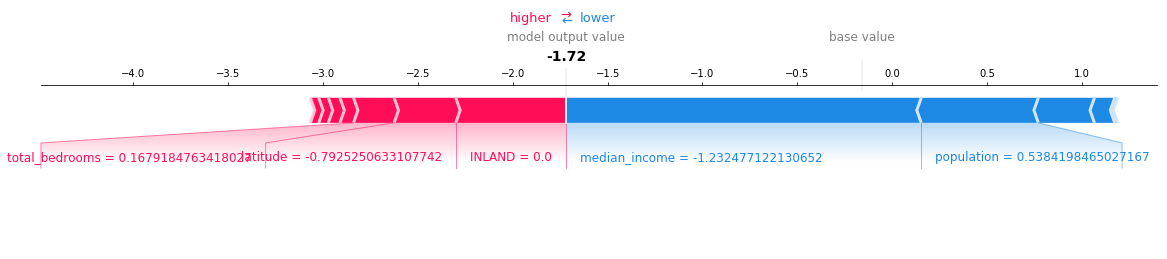

Force Plot of observation 3627


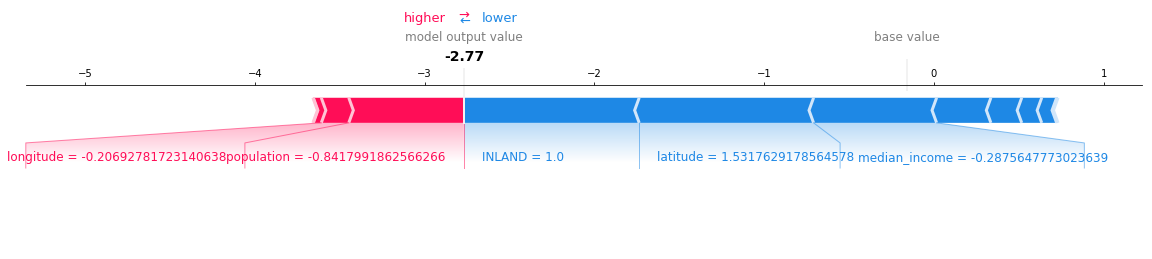

Force Plot of observation 5400


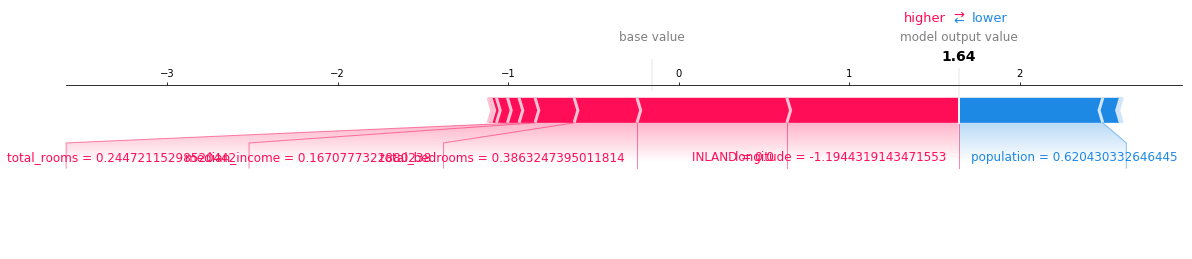

In [28]:
# random sample 3 observations
random_obs = random.sample(range(len(test_x_trans[select])), 3)

for ob in random_obs:
    #plot the SHAP values for the random sampled observations
    print(f"Force Plot of observation {ob}")
    shap.force_plot(np.around(expected_value, decimals=4), 
                       np.around(shap_values[ob],decimals=4), 
                       test_x_trans[ob], 
                       feature_names= new_col_list,
                       show=False,matplotlib =True )
    plt.show()

      

### Decision Plot

#### 1)shap.decision_plot(collective)

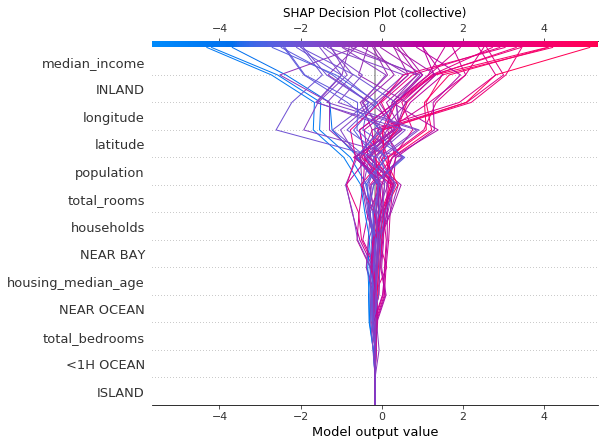

In [29]:
# Plot collective decision plot for 50 data points
rcParams['axes.titlepad'] = 24
r = shap.decision_plot(expected_value, shap_values[:50], test_x_trans[select][:50],
                        feature_names= new_col_list, show= False,return_objects=True)
plt.title("SHAP Decision Plot (collective)")
plt.savefig("SHAP_decision_plot_collective.png")
plt.show()


- The decision plot above show 50 instances in the explaining set
- There are two x-axes, top and bottom, representing the model output in the feature spacpe
    * the bottom x-axis shows the base value (explainer.expected_value). This is where the decision-tree of all instances started (to grow)
    * the top x-axis shows the final model prediction for each instance (each instance landed differently)
- The y-axis lists the model's features. By default, the features are ranked by feature SHAP value in descending order
- Each instance is represented by one colored line. The path of how a line grows from the bottom to the top represents how features of that instance affected the model prediction
- As SHAP values are in the same unit as the model's output value, the magnitude of each step from one feature to another along the path represents how big the contribution by that feature, and the color presents positive (in red) or negative effect (in blue)
- For each individual instance, SHAP value for each feature are added to the model's base value to get to the final model output for that particular instance. In the decision plot, each line presents one instance. As a line grows from the bottom to the top, the path shows how features work together to finally arrives at the model prediction for that particular instance.


#### 2)shap.decision_plot (predicted probability)
Like the force plot, the decision plot supports link='logit' to transform log odds to probabilities.  The interpretation is the same as the collective plot, except for now the x-axes are in the unit of prediction probabilities. 
 

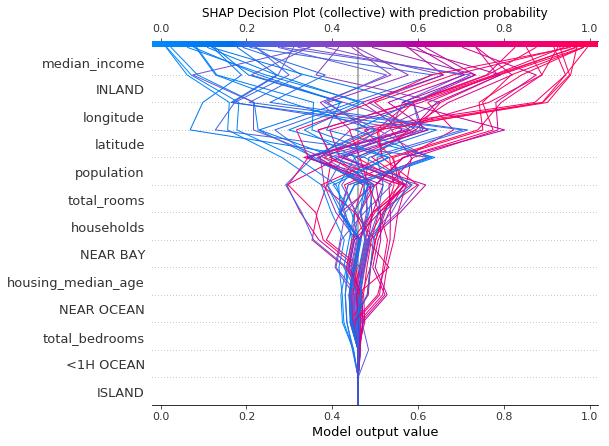

In [30]:
#Plot decision plot by assigning link='logit' to transform log odds to probabilities.
shap.decision_plot(expected_value,
                   shap_values[:50],
                   test_x_trans[select][:50],
                   feature_names= new_col_list,  link='logit',
                   show= False)
plt.title("SHAP Decision Plot (collective) with prediction probability")
plt.savefig("SHAP_decision_plot_collective.png")
plt.show()


#### 3)shap.decision_plot (single instance)
SHAP provides the option to create decision plot for a single instance. The interpretation is the same as the collective plot, except for now we only one instance of choice.

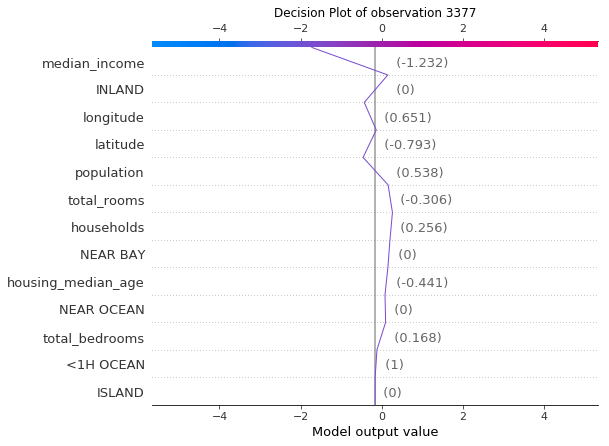

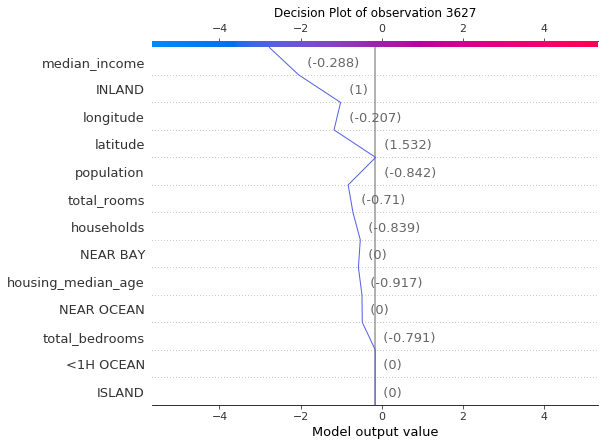

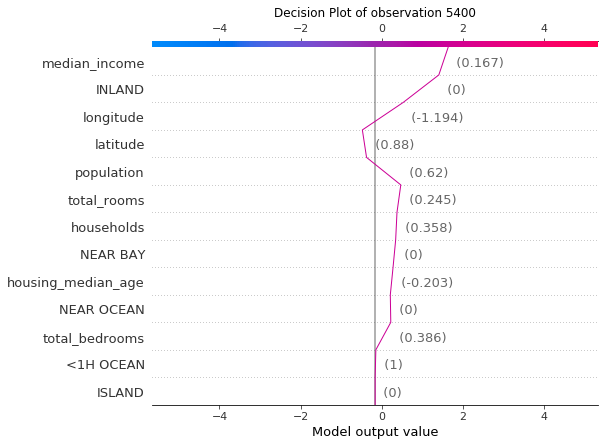

In [31]:
# create decision plot for 3 randomized selected samples
rcParams['axes.titlepad'] = 24

for ob in random_obs:
    #plot the SHAP values for the random sampled observations
    shap.decision_plot(expected_value,
                       shap_values[ob], 
                       test_x_trans[ob], 
                       feature_names= new_col_list,
                       feature_order=r.feature_idx, 
                       xlim=r.xlim,
                       show=False)
    plt.title(f"Decision Plot of observation {ob}")
    plt.savefig(f"decision_plot_ob_{ob}.png") 
    plt.show()

#### 4)shap.decision_plot (with SHAP Interaction Values and in predicted probability)
SHAP provides the option to create decision plot that includes interaction terms 

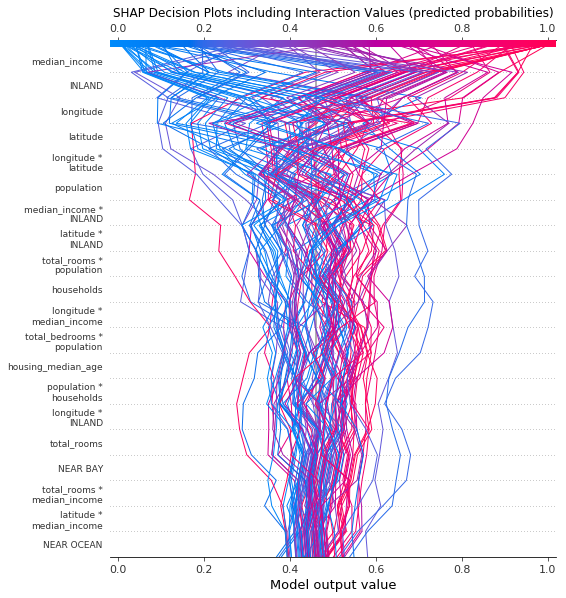

In [35]:
shap.decision_plot(expected_value, shap_interaction_values[0:100], 
                   test_x_trans[0:100], link='logit',
                  feature_names= new_col_list, show=False)
plt.title("SHAP Decision Plots including Interaction Values (predicted probabilities)")
plt.show()
           

### waterfall plot
The waterfall plot is another option to understand how features effect the model prediction at a single observation level.

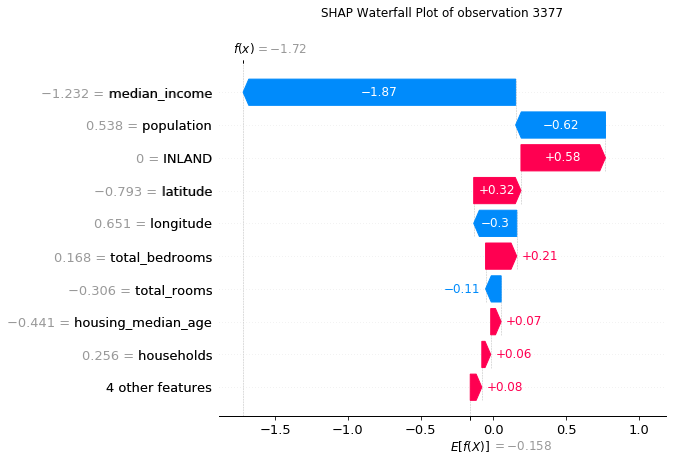

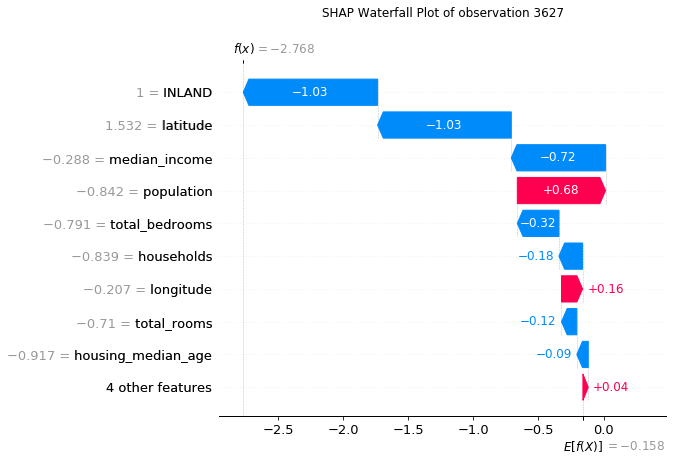

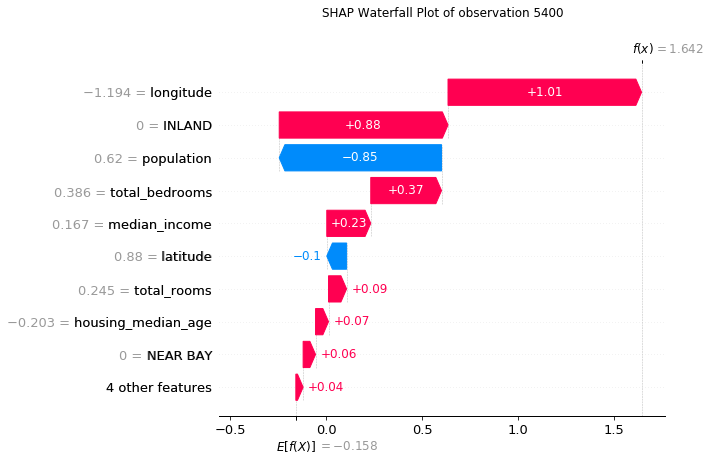

In [32]:
# plot waterfall plot
for ob in random_obs:
    #plot the SHAP values for the random sampled observations
    shap.waterfall_plot(expected_value,
                           shap_values[ob], 
                           test_x_trans[ob], 
                           feature_names= new_col_list,
                           show=False)
    plt.title(f"SHAP Waterfall Plot of observation {ob}")
    plt.savefig(f"shap_waterfall_plot_ob_{ob}.png") 
    plt.show()

- The x-axis represents model output values (log-odds in this example)
- The y-axis shows the features ranked by SHAP values in descending order along with each feature’s name and the value for the current observation
- The value at the bottom of the plot (-0.158) on x-axis represent base value (explainer.expected_value)
- Starting from the bottom of the plot moving up, each feature either increases the model output from the base value with a red arrow pointing right or deceases model output with a blue arrow pointing left. The length of the arrow indicating the magnitude of SHAP value for that feature value
- The x value at the very top of the plot is where the final model predicted value for this observation


### Bonus Section: 
#### Prove of SHAP values in the same unit as the model outputs
In this tutorial, SHAP values has unit of log-odds (as the output by GradientBoosting model). See prove below using instance 0 as example

In [36]:
# get predicted probability for instance 0
gb_clf.predict_proba(test_x_trans[0].reshape(1, -1))

array([[0.98516513, 0.01483487]])

In [37]:
# compute shap values for instance 0
shap_values_0 = explainer.shap_values(test_x_trans[0].reshape(1, -1))
# the shap values for instance 0 plus expected values is the log-odds for instance 0
log_odd_0 = np.exp(shap_values_0.sum() + explainer.expected_value)

In [38]:
#convert log-odds to probability, which equals the probability predicted by the model
log_odd_0/(1+log_odd_0)

0.014834865054111563


#### Surprise ! Additional Bonus : Vocabulary for SHAP library

**explainer** (shap.explainer_type(params))
- type of explainer algorithm to be chosen from SHAP library according to the model type

**background dataset**
- The X matrix (or part of) to provide to SHAP explainer when initiating the explainer

**explainer.expected_value**
- Returns the base value of the model, that is the average of all predictions by the model. All SHAP values are relative to the model's expected value like a linear model's effects are relative to the intercept.

**explaining set**
- The X matrix to intended to be explained by SHAP explainer

**Shap values**
- explainer.shap_values(params)
- The SHAP value of a feature value represents how much that feature value changes the output of the model from the base value (the average of all model predictions)

**output value** (for an instance)
- The value predicted by the model on an instance (the probability, logit or raw output values of the model)

